In [0]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### RAVDESS DATASET

In [0]:
# Data Directory
# Please edit according to your directory change.
Ravdess_paths= np.array(("/content/gdrive/My Drive/Colab Notebooks/Ravdess_Audio_Speech_Actors_01-24/","/content/gdrive/My Drive/Colab Notebooks/Ravdess_Audio_Song_Actors_01-24/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [0]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path) 
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [0]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,neutral
1,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,2,calm
2,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,neutral
3,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,neutral
4,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,neutral


In [0]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test', 
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [0]:
ravdess_db['split'].value_counts()

Train    2036
Val       208
Test      208
Name: split, dtype: int64

In [0]:
ravdess_db.shape

(2452, 7)

In [0]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'
ravdess_db.index = range(len(ravdess_db.index))

In [0]:
ravdess_db.shape

(2260, 7)

In [0]:
ravdess_db.emotion_lb.value_counts()

neutral    564
angry      376
fearful    376
sad        376
happy      376
disgust    192
Name: emotion_lb, dtype: int64

In [0]:
dataset_db = ravdess_db.copy()

In [0]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [0]:
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
0,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,male_neutral,Train
1,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,male_neutral,Train
2,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,male_neutral,Train
3,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,male_neutral,Train
4,/content/gdrive/My Drive/Colab Notebooks/Ravde...,Ravdess,1,male,1,male_neutral,Train


In [0]:
dataset_db.shape

(2260, 7)

In [0]:
dataset_db.emotion_lb.value_counts()

male_neutral      288
female_neutral    276
male_angry        192
male_sad          192
male_happy        192
male_fearful      192
female_happy      184
female_fearful    184
female_angry      184
female_sad        184
female_disgust     96
male_disgust       96
Name: emotion_lb, dtype: int64

In [0]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration


In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
signal, sample_rate = librosa.load(dataset_db.path[52], res_type='kaiser_fast',sr=22050*2)
signal,index = librosa.effects.trim(signal,top_db = 25)
signal = scipy.signal.wiener(signal)

if len(signal) > input_length:
    signal = signal[0:input_length]
elif  input_length > len(signal):
    max_offset = input_length - len(signal)  
    signal = np.pad(signal, (0, max_offset), "constant")

In [0]:
signal = np.array(signal).reshape(-1,1)

In [0]:
signal.shape

(66150, 1)

In [0]:
audios= np.empty(shape=(dataset_db.shape[0], input_length,1))

count=0
for i in tqdm(range(len(dataset_db))):
    signal, sample_rate = librosa.load(dataset_db.path[i], res_type='kaiser_fast',sr=22050)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)
    
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    signal  = np.array(signal).reshape(-1,1)
    #signal =  np.expand_dims(signal,axis=2)
    audios[count,] =  signal
    count+=1

In [0]:
audios.shape

(2260, 66150, 1)

In [0]:
import h5py
with h5py.File('/content/gdrive/My Drive/Colab Notebooks/Ravdess_audio_full.h5', 'w') as hf:
    hf.create_dataset("Ravdess_audio_data",  data=audios)

In [0]:
import h5py
with h5py.File('/content/gdrive/My Drive/Colab Notebooks/Ravdess_audio_full.h5', 'r') as hf:
    audios = hf['Ravdess_audio_data'][:]
    

In [0]:
dataset_db.to_csv('/content/gdrive/My Drive/Colab Notebooks/ravdess_list.csv')

In [0]:
x_train = audios[(dataset_db['split'] == 'Train')]
y_train = dataset_db.emotion_lb[(dataset_db['split'] == 'Train')]

print(x_train.shape,y_train.shape)

(1876, 66150, 1) (1876,)


In [0]:
x_test = audios[(dataset_db['split'] == 'Val')]
y_test = dataset_db.emotion_lb[(dataset_db['split'] == 'Val')]

print(x_test.shape,y_test.shape)

(192, 66150, 1) (192,)


In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [0]:
x_traincnn = x_train
x_testcnn = x_test

In [0]:
x_traincnn.shape,x_testcnn.shape,y_train.shape,y_test.shape

((1876, 66150, 1), (192, 66150, 1), (1876, 12), (192, 12))

In [0]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train, 1)))
input_shape = x_traincnn.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 64


In [0]:
input_shape

(66150, 1)

In [0]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(12), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=12, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=12, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=12, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
model.summary()

Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 66150, 64)         832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 66150, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 66150, 64)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16537, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16537, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16537, 64)         49216     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16537, 64)        

In [0]:
#Train Config

batch_size = 16
num_epochs = 100

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Models/Audio_1DCNN_k12.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1876 samples, validate on 192 samples
Epoch 1/100





1876/1876 [==============================] - 62s 33ms/step - loss: 2.4722 - categorical_accuracy: 0.1173 - val_loss: 2.4246 - val_categorical_accuracy: 0.1302
Epoch 2/100
1876/1876 [==============================] - 53s 28ms/step - loss: 2.4442 - categorical_accuracy: 0.1391 - val_loss: 2.3780 - val_categorical_accuracy: 0.1250
Epoch 3/100
1876/1876 [==============================] - 53s 28ms/step - loss: 2.3978 - categorical_accuracy: 0.1604 - val_loss: 2.3608 - val_categorical_accuracy: 0.1771
Epoch 4/100
1876/1876 [==============================] - 53s 28ms/step - loss: 2.2966 - categorical_accuracy: 0.1764 - val_loss: 2.6860 - val_categorical_accuracy: 0.1250
Epoch 5/100
1876/1876 [==============================] - 53s 28ms/step - loss: 2.1973 - categorical_accuracy: 0.2127 - val_loss: 2.0646 - val_categorical_accuracy: 0.2

In [0]:
max(cnnhistory.history['val_categorical_accuracy'])

0.5885416666666666

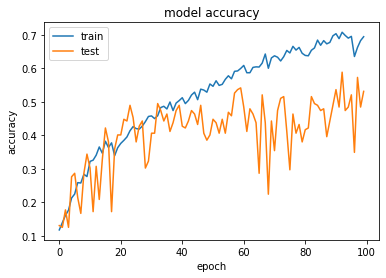

In [0]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

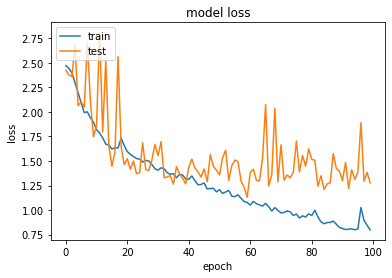

In [0]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Saving the model.json

import json
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/Models/Audio_1DCNN_4L_K12_LSTM.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/Colab Notebooks/Models/Audio_1DCNN_4L_K12_LSTM.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [0]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
loaded_model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Models/Audio_1DCNN_k12.h5')

In [0]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 58.85%


In [0]:
x_test_data = audios[(dataset_db['split'] == 'Test')]
y_test_data = dataset_db.emotion_lb[(dataset_db['split'] == 'Test')]

print(x_test_data.shape,y_test_data.shape)

(192, 66150, 1) (192,)


In [0]:
preds = loaded_model.predict(x_test_data,batch_size=16,verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

192/192 [==============================] - 2s 11ms/step


In [0]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_happy
1,male_fearful
2,male_fearful
3,male_sad
4,male_sad
5,male_sad
6,male_fearful
7,female_sad
8,male_fearful
9,male_sad


In [0]:
preddf.shape

(192, 1)

In [0]:
actualdf = pd.DataFrame({'actualvalues': y_test_data})
actualdf[:10]
actualdf.index = range(len(actualdf.index))

In [0]:
actualdf.head()

,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_neutral


In [0]:
finaldf = pd.concat([actualdf,preddf],axis=1)
finaldf.head()

,actualvalues,predictedvalues
0,male_neutral,male_happy
1,male_neutral,male_fearful
2,male_neutral,male_fearful
3,male_neutral,male_sad
4,male_neutral,male_sad


In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [0]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

46.35416666666667

In [0]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

41.76620656606503

In [0]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[ 5,  2,  0,  5,  2,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  3,  1,  2,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  9,  5,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  1, 21,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  0, 11,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0,  7,  1,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  2,  0,  4,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  0,  1,  2,  9,  2,  0,  1],
       [ 0,  2,  0,  0,  0,  2,  0,  0,  4,  4,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  1, 12,  7],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  3,  1,  5,  5]])

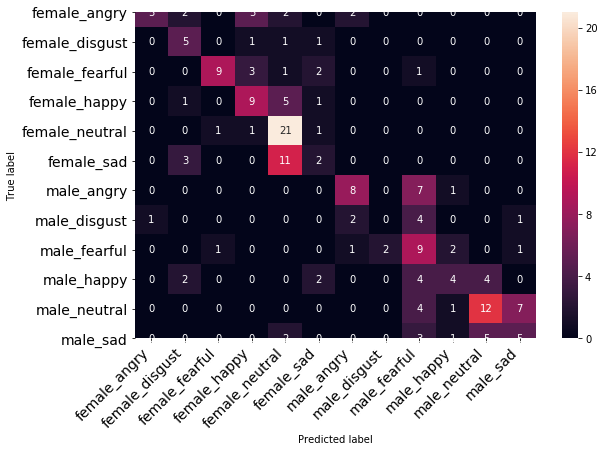

In [0]:
class_names=sorted(set(finaldf.actualvalues))
print_confusion_matrix(c, class_names)
